In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical
import PIL 
import os
import cv2
from PIL import Image 
from numpy import asarray 
import matplotlib.pyplot as plt

In [2]:
directory  = "./DataSet"

In [3]:
len_of_word = 5

In [4]:
vec =[]
c = '0'
for i in range (10):
    vec.append(c)
    c = chr(ord(c) + 1) 
c = 'a'
for i in range (26):
    vec.append(c)    
    c = chr(ord(c) + 1)
print(vec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
def class_indices(label):
    ans = np.zeros(len(label))
    j = 0
    for ind in label:
        for i in range (36):
            if(vec[i]==ind):
                ans[j] = i
                j+=1
                break
    #ans = np.asarray(ans).astype('float32')
    #print(ans)
    return ans

In [6]:
def parse_filepath(filepath):
    path, filename = os.path.split(filepath)
    filename, ext = os.path.splitext(filename)
    label = filename.split("_")
    p = class_indices(label)
    cnt=0
    return label

In [7]:
import glob


files = glob.glob(os.path.join(directory,"*.jpg"))
# print(files)
labels = list(files)
labels = list(map(parse_filepath,files))
# print(labels)
df = pd.DataFrame(labels)
df['filepath'] = files
df.columns = ['labels','filepath']
df.dropna()
df.head()
#df.describe()

,labels,filepath
0,2a6y6,./DataSet/2a6y6.jpg
1,2a2yx,./DataSet/2a2yx.jpg
2,2a5pf,./DataSet/2a5pf.jpg
3,2a5cn,./DataSet/2a5cn.jpg
4,2a6yy,./DataSet/2a6yy.jpg


In [8]:
def pass_Data(df,indices,training_bool,batch_size=16):
    images = []
    labels = []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['filepath'], r['labels']
            #print(label)
            im = Image.open(file)
            im = im.resize((227, 227))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            # 2a341 = (2,11,3,4,1)
            l = to_categorical(class_indices(label),36)
            labels = np.append(labels,l)
            # 9*36*5
            #(9*36*5,)
            #(9,36*5)
            if len(images) >= batch_size:
                row = int((int(labels.shape[0]))/(36*len_of_word))
                col = int((int(labels.shape[0]))/(row))          
                labels = labels.reshape(row,col)
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not training_bool:
            break

In [9]:
# Test place #
# images = []
# labels = []
# for i in range(len(df)):
#     r = df.iloc[i]
#     file, label = r['filepath'], r['labels']
#     #print(label)
#     l = to_categorical(class_indices(label),36)
#     labels = np.append(labels,l)
#     #labels = np.asarray(labels)
# print(labels.shape)
# row = int((int(labels.shape[0]))/(36*len_of_word))
# col = int((int(labels.shape[0]))/(row))          
# labels = labels.reshape(row,col)
# print(labels.shape)

In [10]:
# Splitting the data set into test train and validation set

p = np.random.permutation(len(df)) # random images are distributed.
train_up_to = int(len(df) * 0.8) # the train and the test set is divided into 80:20 
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.8) # the train set is further divided into the validation and the training data set
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 5, valid count: 2, test count: 2


In [11]:
#  Generating the test and the validation data 

batch_size = 2# insert Number
valid_batch_size = 1 #inset Number 

# def pass_Data(df,indices,training_bool,batch_size=16)
train_gen = pass_Data(df,train_idx,True,batch_size = batch_size)
validation_gen = pass_Data(df,valid_idx,True,batch_size = valid_batch_size)
test_gen = pass_Data(df, test_idx, training_bool=True, batch_size=1)

In [12]:
# To calculate the validation and the training steps

validation_steps = (len(valid_idx)//valid_batch_size)
train_steps = (len(train_idx)//batch_size)
print(validation_steps,train_steps)

2 2


In [13]:
score = 0

In [14]:
#  Alex_net Model making
def Alex_net():
#     THe input shape is always 257*257*3 or 256*256*3 and the images should be reshaped into it, if it is not that currently
    image_shape = (227,227,3)
    np.random.seed(1000)
    model = Sequential()
#     First Layer which is the convolution Layer
    model.add(Conv2D(filters = 96,input_shape = image_shape,kernel_size=(11,11),strides=(4,4),padding = 'valid'))
    model.add(Activation('relu'))
#     Next is the Pooling layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding = 'valid'))

#     The first convolution and max pooling layer is done .

#     Second Layer 
    model.add(Conv2D(filters = 256,kernel_size=(5,5),strides=(1,1),padding = 'valid'))
    model.add(Activation('relu'))
#     Next is the Pooling layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding = 'valid'))
    
#     Second Layer Done 

#     Third Layer is only the convolution layer. There is no maxPooling layer at all

    model.add(Conv2D(filters = 384,kernel_size=(3,3),strides=(1,1),padding = 'valid'))
    model.add(Activation('relu'))

# Fourth layer- only convolution layer
    
    model.add(Conv2D(filters = 384,kernel_size=(3,3),strides=(1,1),padding = 'valid'))
    model.add(Activation('relu'))
    
# Fifth layer- one convolution and one pooling layer
    model.add(Conv2D(filters = 256,kernel_size=(3,3),strides=(1,1),padding = 'valid'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding = 'valid'))

        
    model.add(Flatten())
# Sixth fully connected layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
#Seventh fully connected layer
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
#Final softmax layer
    model.add(Dense(36*5))
#     model.resize()
    model.add(Activation('softmax'))
    
    model.summary()
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])
    
    
    return model

In [15]:
model = Alex_net()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 23, 23, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

In [16]:
History = model.fit(train_gen,steps_per_epoch= train_steps,epochs = 2,validation_data = validation_gen, validation_steps = validation_steps)

Epoch 1/2
2/2 [==============================] - 2s 814ms/step - loss: 23.9972 - accuracy: 0.1667 - val_loss: 462.0040 - val_accuracy: 1.0000
Epoch 2/2
2/2 [==============================] - 1s 299ms/step - loss: 1233.8461 - accuracy: 0.5000 - val_loss: 21287.6953 - val_accuracy: 1.0000


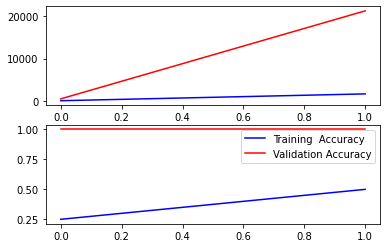

In [17]:
f,ax=plt.subplots(2,1)
ax[0].plot(History.history['loss'],color='b',label='Training Loss')
ax[0].plot(History.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(History.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(History.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [29]:
score = model.evaluate(test_gen,steps = 12)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 28ms/step - loss: 24236.6641 - accuracy: 1.0000
Test loss: 24236.6640625
Test accuracy: 1.0


In [19]:
# for i in test_gen:
#     print(i)